In [1]:
# Standard Library Imports
import os
from os import listdir
from os.path import join
import sys
import random
from random import shuffle
from random import randint
import pickle

# Third-Party Imports
import tensorflow as tf
import keras
import keras.backend as K
from keras import optimizers
from keras import regularizers
from keras.models import model_from_json
from keras.models import load_model
from keras.models import Sequential
from keras.models import Model
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers import Conv3D
from keras.layers import MaxPooling3D
from keras.layers import ZeroPadding3D
from keras.layers.core import Flatten
# from keras.callbacks import ModelCheckpoint
# from keras.callbacks import EarlyStopping
# from keras.callbacks import TensorBoard
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation
import cv2
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools
from IPython.display import display
from JSAnimation import IPython_display
from IPython.display import HTML

# Local Imports
import c3d_model
import clip_dataset
from clip_dataset import DataGenerator
import config_clips

/home/ljames/py-3.5/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Use tf backend
dim_ordering = K.image_dim_ordering()
print("[Info] image_dim_order (from default ~/.keras/keras.json)={}".format(
        dim_ordering))
backend = dim_ordering

[Info] image_dim_order (from default ~/.keras/keras.json)=tf


In [3]:
def play_video(vid, size):
    html_code = """
    <video width="{}" height="{}" controls>
      <source src={} type="video/mp4">
    </video>""".format(size[0], size[1], vid)
    return html_code

In [4]:
def get_partitions(PATH):
    """
    Return dictionary that places each filename into
    a list with the parent dataset (train/valid/test) as the key
    """
    datasets = listdir(PATH)
    # print('datasets are: {}'.format(datasets))
    partitions = {d:[] for d in datasets}

    for d in datasets:
        classes = listdir(join(PATH, d))
        for c in classes:
            files = listdir(join(PATH, d, c))
            [partitions[d].append(join(PATH, d, c, f)) for f in files]
        # Randomize order
        shuffle(partitions[d])

    return partitions

In [5]:
def get_best_model(model_dir, metric='acc'):
    """
    Return path to model weights with either lowest
    loss or highest accuracy
    """
    # Get all paths
    paths = listdir(model_dir)
    
    # Get only weight files
    weights = [p for p in paths if p[-5:] == '.hdf5']
    
    # Get only type of weights that were saved by desired metric
    weights = [w for w in weights if metric in w]

        
    vals = [float(w.rsplit('.hdf5', 1)[0].rsplit('-', 1)[-1]) for w in weights]
    if metric == 'acc':
        best_val = max(vals)
    else:
        best_val = min(vals)
        
    best_model = weights[vals.index(best_val)]
    return join(model_dir, best_model)

In [6]:
def get_labels(PATH, classes_to_nums):
    """
    Return dictionary that places each filename into
    a list with the parent dataset as the key
    """
    datasets = listdir(PATH)
    print('datasets are: {}'.format(datasets))
    labels = {}

    for d in datasets:
        classes = listdir(join(PATH, d))
        for c in classes:
            files = listdir(join(PATH, d, c))
            num = classes_to_nums[c]
            temp = {join(PATH, d, c, f):num for f in files}
            labels = {**temp, **labels}

    return labels

In [7]:
def make_predictions(model, data_gen):
    """Gets a batch from a data_gen and gets predictions on it"""
    batch = randint(0, data_gen.__len__())
    data_x, data_y = data_gen.__getitem__(batch)
    if model is None:
        return data_x, data_y, None
    else:
        prediction_results = model.predict_on_batch(data_x)
        return data_x, data_y, prediction_results

In [8]:
def plot_predictions(r, c, data_x, data_y, probs, classes):
    """
    Creates a grid of plots of predictions and goundtruth labels of 
    input images
    """

    fig, axes = plt.subplots(r, c)
    fig.set_figheight(r * 6)
    fig.set_figwidth(c * 10)
    for i in range(r*c):

        # Read image into RGB format
        img = np.asarray(data_x[i, 0, :, :, :])
        # img = np.reshape(img, [1280, 720, 3])
        
        mean_cube = np.load('models/train01_16_128_171_mean.npy')
        mean_cube = np.transpose(mean_cube, (1, 2, 3, 0))
        mean_cube = mean_cube[:, 8:120, 30:142, :]
        # img += mean_cube[0, :, :, :]

        # get predicted and groudtruth labels
        lbl = data_y[i][0]
        pred = probs[i]
        pred = [round(z*1000)/1000 for z in pred]
        prb = probs[i][0]
        if prb > 0.5:
            cls = classes[0]
        else:
            cls = classes[1]

        if lbl > 0.5:
            lbl = classes[0]
        else:
            lbl = classes[1]
        
        # Add to subplot
        row = i % r
        col = i // r
        axes[row, col].imshow((img + mean_cube[0, :, :, :]) / 256)
        axes[row, col].set_title('out:{}, pred:{}, truth:{}'.format(
            pred, cls, lbl))
    plt.show()

In [9]:
def plot_movie_array_js(r, c, data_x, data_y, probs, classes):
    """
    Plots an array of movies with their predictions and
    groud truth labels as the titles
    """
    
    fig, axes = plt.subplots(r, c)
    fig.set_figheight(r * 10)
    fig.set_figwidth(c * 10)
    mean_cube = np.load('models/train01_16_128_171_mean.npy')
    mean_cube = np.transpose(mean_cube, (1, 2, 3, 0))
    mean_cube = mean_cube[:, 8:120, 30:142, :]
    # img += mean_cube[0, :, :, :]   

    def animate(z):
        for i in range(r*c):

            # get predicted and groudtruth labels
            lbl = data_y[i][0]
            pred = probs[i]
            pred = [round(z*1000)/1000 for z in pred]
            prb = probs[i][0]
            if prb > 0.5:
                cls = classes[0]
            else:
                cls = classes[1]

            if lbl > 0.5:
                lbl = classes[0]
            else:
                lbl = classes[1]

            # Add to subplot
            row = i % r
            col = i // r
            img = (data_x[i, :, :, :, :] + mean_cube) / 256 
            axes[row, col].imshow(img[z]).set_array(img[z])
            axes[row, col].set_title(
                        'out:{}, pred:{}, truth:{}'.format(pred, cls, lbl), 
                        fontsize=20)
        return (im,)

    anim = animation.FuncAnimation(fig, animate, frames=16)
    display(IPython_display.display_animation(anim))

In [10]:
def plot_movie_js(image_array):
    dpi = 72.0
    xpixels, ypixels = image_array[0].shape[0], image_array[0].shape[1]
    fig = plt.figure(figsize=(ypixels/dpi, xpixels/dpi), dpi=dpi)
    im = plt.figimage(image_array[0])
    plt.axis('off')

    def animate(i):
        im.set_array(image_array[i])
        return (im,)

    anim = animation.FuncAnimation(fig, animate, frames=len(image_array))
    display(IPython_display.display_animation(anim))

In [11]:
def predictions_over_entire_gen(model, data_gen):
    """Gets a batch from a data_gen and gets predictions on it"""
    predictions = []
    truth = []
    # diffs = []
    imgs = []
    for i in range(0, data_gen.__len__()):
        data_x, data_y = data_gen.__getitem__(i)
        # print(int(round(model.predict_on_batch(data_x)[0][1])))
        truth.append(int(round(data_y[0][1])))
        predictions.append(model.predict_on_batch(data_x)[0][1])
        imgs.append(i)

    return truth, predictions, imgs

In [12]:
def predict_class_over_entire_gen(model, data_gen):
    """Gets a batch from a data_gen and gets predictions on it"""
    predictions = []
    truth = []
    for i in range(0, data_gen.__len__()):
        data_x, data_y = data_gen.__getitem__(i)
        # print(int(round(model.predict_on_batch(data_x)[0][1])))
        truth.append(int(round(data_y[0][1])))
        predictions.append(int(round(model.predict_on_batch(data_x)[0][1])))
    return truth, predictions

In [13]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [14]:
def load_model(dense_activation='relu'):
    pretrained_model_dir = './models'
    global backend

    print("[Info] Using backend={}".format(backend))

    model_weight_filename = join(pretrained_model_dir, 'sports1M_weights_tf.h5')
    model_json_filename = join(pretrained_model_dir, 'sports1M_weights_tf.json')

    model = Sequential()
    input_shape=(16, 112, 112, 3) # l, h, w, c

    model.add(Conv3D(64, (3, 3, 3), activation='relu',
                            border_mode='same', name='conv1',
                            input_shape=input_shape))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2),
                           border_mode='valid', name='pool1'))
    # 2nd layer group
    model.add(Conv3D(128, (3, 3, 3), activation='relu',
                            border_mode='same', name='conv2'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2),
                           border_mode='valid', name='pool2'))
    # 3rd layer group
    model.add(Conv3D(256, (3, 3, 3), activation='relu',
                            border_mode='same', name='conv3a'))
    model.add(Conv3D(256, (3, 3, 3), activation='relu',
                            border_mode='same', name='conv3b'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2),
                           border_mode='valid', name='pool3'))
    # 4th layer group
    model.add(Conv3D(512, (3, 3, 3), activation='relu',
                            border_mode='same', name='conv4a'))
    model.add(Conv3D(512, (3, 3, 3), activation='relu',
                            border_mode='same', name='conv4b'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2),
                           border_mode='valid', name='pool4'))
    # 5th layer group
    model.add(Conv3D(512, (3, 3, 3), activation='relu',
                            border_mode='same', name='conv5a'))
    model.add(Conv3D(512, (3, 3, 3), activation='relu',
                            border_mode='same', name='conv5b'))
    model.add(ZeroPadding3D(padding=((0, 0), (0, 1), (0, 1)), name='zeropad5'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2),
                           border_mode='valid', name='pool5'))
    model.add(Flatten(name='flatten_1'))
    # FC layers group
    model.add(Dense(128, activation=dense_activation, name='fc6_lees'))
    model.add(Dropout(.5, name='dropout_1_lees'))
    model.add(Dense(128, activation=dense_activation, name='fc7_lees'))
    model.add(Dropout(.5, name='dropout_2_lees'))
    model.add(Dense(2, activation='softmax', name='fc8_lees'))

    print("[Info] Loading model weights...")    
    model.load_weights(model_weight_filename, by_name=True, skip_mismatch=True)
    print("[Info] Loading model weights -- DONE!")

    return model

In [15]:
def run_and_save_inference_results(model, dataset_generator, path, trials=3):
    inference_results = []
    for i in range(trials):
        single_inference = model.evaluate_generator(generator=dataset_generator)
        inference_results.append(single_inference)
    pickle.dump(inference_results, open(path, "wb" ))
    return inference_results

In [16]:
def run_verbose_inference(model, model_dir, training_generator, validation_generator, testing_generator):
    
    # Run inference on model as is, model with the best validation accuracy, and model with the best validation loss
    metric = 'final'
    run_and_save_inference_results(model, training_generator, join(model_dir, metric + '_training_results.pkl'), trials=1)
    run_and_save_inference_results(model, validation_generator, join(model_dir, metric + '_validation_results.pkl'), trials=5)
    run_and_save_inference_results(model, testing_generator, join(model_dir, metric + '_testing_results.pkl'), trials=5)

    metric = 'acc'
    best_model = get_best_model(model_dir, metric=metric)
    model.load_weights(best_model)
    run_and_save_inference_results(model, training_generator, join(model_dir, metric + '_training_results.pkl'), trials=1)
    run_and_save_inference_results(model, validation_generator, join(model_dir, metric + '_validation_results.pkl'), trials=5)
    run_and_save_inference_results(model, testing_generator, join(model_dir, metric + '_testing_results.pkl'), trials=5)

    metric = 'loss'
    best_model = get_best_model(model_dir, metric=metric)
    model.load_weights(best_model)
    run_and_save_inference_results(model, training_generator, join(model_dir, metric + '_training_results.pkl'), trials=1)
    run_and_save_inference_results(model, validation_generator, join(model_dir, metric + '_validation_results.pkl'), trials=5)
    run_and_save_inference_results(model, testing_generator, join(model_dir, metric + '_testing_results.pkl'), trials=5)

In [17]:
def get_callbacks(model_dir, patience=500):
    filepath_acc = join(
                    model_dir, 
                    "weights-acc-improvement-{epoch:03d}-{val_acc:.4f}.hdf5")

    checkpoint_acc = keras.callbacks.ModelCheckpoint(
                                                filepath_acc, 
                                                monitor='val_acc', 
                                                verbose=1, 
                                                save_best_only=True, 
                                                mode='max')

    filepath_loss = join(
                    model_dir, 
                    "weights-loss-improvement-{epoch:03d}-{val_loss:.4f}.hdf5")

    checkpoint_loss = keras.callbacks.ModelCheckpoint(
                                                filepath_loss, 
                                                monitor='val_loss', 
                                                verbose=1, 
                                                save_best_only=True, 
                                                mode='min')


    early_stopping = keras.callbacks.EarlyStopping(
                                                monitor='val_loss', 
                                                min_delta=0, 
                                                patience=patience, 
                                                verbose=0, 
                                                mode='auto')

    filepath_tb = join(model_dir, "Graph")

    tbCallBack = keras.callbacks.TensorBoard(log_dir=filepath_tb, histogram_freq=0, write_graph=True, write_images=True)

    callbacks_list = [checkpoint_acc, checkpoint_loss, early_stopping, tbCallBack]

    return callbacks_list

# Load All Data

In [18]:
PATH = config_clips.dataset_dir
model_dir = config_clips.models_dir
classes_to_nums = config_clips.classes_to_nums
model_name = config_clips.model_name
train_params = config_clips.train_params
valid_params = config_clips.valid_params
test_params = config_clips.test_params
history_name = config_clips.history_name

In [19]:
if not os.path.isdir(model_dir):
    os.makedirs(model_dir)

In [20]:
partition = get_partitions(PATH)
labels = get_labels(PATH, classes_to_nums)

datasets are: ['b', 'j', 'h', 'a', 'f', 'e', 'd', 'i', 'c', 'g']


In [21]:
# Generators
training_paths = []
for folder in ['b', 'h', 'a', 'f', 'e', 'd', 'c', 'g']:
    training_paths = training_paths + partition[folder]
    
training_generator = DataGenerator(training_paths, labels, **train_params)
validation_generator = DataGenerator(partition['i'], labels, **valid_params)
testing_generator = DataGenerator(partition['j'], labels, **test_params)

## Ensure training data looks as expected

In [22]:
x,y = training_generator.__getitem__(randint(0, training_generator.__len__()))

Image size initially: (480, 848, 3)
Image size after resize: (118, 208, 3)
Image size finally: (112, 112, 3)
Image size initially: (480, 848, 3)
Image size after resize: (118, 208, 3)
Image size finally: (112, 112, 3)
Image size initially: (480, 848, 3)
Image size after resize: (118, 208, 3)
Image size finally: (112, 112, 3)
Image size initially: (480, 848, 3)
Image size after resize: (118, 208, 3)
Image size finally: (112, 112, 3)
Image size initially: (480, 848, 3)
Image size after resize: (118, 208, 3)
Image size finally: (112, 112, 3)
Image size initially: (480, 848, 3)
Image size after resize: (118, 208, 3)
Image size finally: (112, 112, 3)
Image size initially: (480, 848, 3)
Image size after resize: (118, 208, 3)
Image size finally: (112, 112, 3)
Image size initially: (480, 848, 3)
Image size after resize: (118, 208, 3)
Image size finally: (112, 112, 3)
Image size initially: (480, 848, 3)
Image size after resize: (118, 208, 3)
Image size finally: (112, 112, 3)
Image size initiall

Image size initially: (480, 848, 3)
Image size after resize: (118, 208, 3)
Image size finally: (112, 112, 3)
Image size initially: (480, 848, 3)
Image size after resize: (118, 208, 3)
Image size finally: (112, 112, 3)
Image size initially: (480, 848, 3)
Image size after resize: (118, 208, 3)
Image size finally: (112, 112, 3)
Image size initially: (480, 848, 3)
Image size after resize: (118, 208, 3)
Image size finally: (112, 112, 3)
Image size initially: (480, 848, 3)
Image size after resize: (118, 208, 3)
Image size finally: (112, 112, 3)
Image size initially: (480, 848, 3)
Image size after resize: (118, 208, 3)
Image size finally: (112, 112, 3)
Image size initially: (480, 848, 3)
Image size after resize: (118, 208, 3)
Image size finally: (112, 112, 3)
Image size initially: (480, 848, 3)
Image size after resize: (118, 208, 3)
Image size finally: (112, 112, 3)
Image size initially: (480, 848, 3)
Image size after resize: (118, 208, 3)
Image size finally: (112, 112, 3)
Image size initiall

Image size initially: (480, 848, 3)
Image size after resize: (118, 208, 3)
Image size finally: (112, 112, 3)
Image size initially: (480, 848, 3)
Image size after resize: (118, 208, 3)
Image size finally: (112, 112, 3)
Image size initially: (480, 848, 3)
Image size after resize: (118, 208, 3)
Image size finally: (112, 112, 3)
Image size initially: (480, 848, 3)
Image size after resize: (118, 208, 3)
Image size finally: (112, 112, 3)
Image size initially: (480, 848, 3)
Image size after resize: (118, 208, 3)
Image size finally: (112, 112, 3)
Image size initially: (480, 848, 3)
Image size after resize: (118, 208, 3)
Image size finally: (112, 112, 3)
Image size initially: (480, 848, 3)
Image size after resize: (118, 208, 3)
Image size finally: (112, 112, 3)
Image size initially: (480, 848, 3)
Image size after resize: (118, 208, 3)
Image size finally: (112, 112, 3)
Image size initially: (480, 848, 3)
Image size after resize: (118, 208, 3)
Image size finally: (112, 112, 3)
Image size initiall

Image size initially: (480, 848, 3)
Image size after resize: (118, 208, 3)
Image size finally: (112, 112, 3)
Image size initially: (480, 848, 3)
Image size after resize: (118, 208, 3)
Image size finally: (112, 112, 3)
Image size initially: (480, 848, 3)
Image size after resize: (118, 208, 3)
Image size finally: (112, 112, 3)
Image size initially: (480, 848, 3)
Image size after resize: (118, 208, 3)
Image size finally: (112, 112, 3)
Image size initially: (480, 848, 3)
Image size after resize: (118, 208, 3)
Image size finally: (112, 112, 3)
Image size initially: (480, 848, 3)
Image size after resize: (118, 208, 3)
Image size finally: (112, 112, 3)


Dirty Lens
(16, 112, 112, 3)


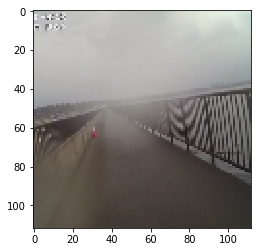

In [51]:
pick_nth = 15
if y[pick_nth][1] == 1:
    print("Clean lens")
else:
    print('Dirty Lens')
# print(y[0])
# print(x[0][0].shape)
# subtract mean
im = x[pick_nth, :, :, :, :]
print(im.shape)
mean_cube = np.load('models/train01_16_128_171_mean.npy')
mean_cube = np.transpose(mean_cube, (1, 2, 3, 0))
mean_cube = mean_cube[:, 8:120, 30:142, :]
im += mean_cube
p = plt.imshow(im[0]/256)


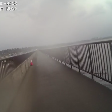
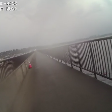
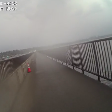
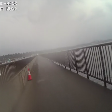
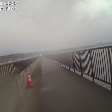
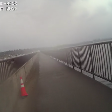
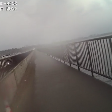
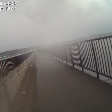
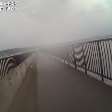
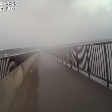
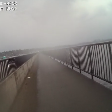
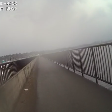
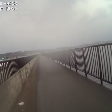
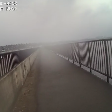
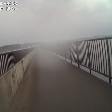
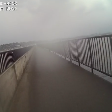

In [52]:
plot_movie_js(im/256)

## Make callbacks to save model

In [24]:
callbacks_list = get_callbacks(model_dir=model_dir, patience=500)

Instructions for updating:
Use the retry module or similar alternatives.


## Load C3D and change last layers

In [33]:
model = load_model(dense_activation='relu')

[Info] Using backend=tf
[Info] Reading model architecture...


/home/ljames/py-3.5/lib/python3.5/site-packages/ipykernel_launcher.py:28: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(64, (3, 3, 3), activation="relu", input_shape=(16, 112, ..., padding="same", name="conv1")`
/home/ljames/py-3.5/lib/python3.5/site-packages/ipykernel_launcher.py:30: UserWarning: Update your `MaxPooling3D` call to the Keras 2 API: `MaxPooling3D(strides=(1, 2, 2), padding="valid", name="pool1", pool_size=(1, 2, 2))`
/home/ljames/py-3.5/lib/python3.5/site-packages/ipykernel_launcher.py:33: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(128, (3, 3, 3), activation="relu", padding="same", name="conv2")`
/home/ljames/py-3.5/lib/python3.5/site-packages/ipykernel_launcher.py:35: UserWarning: Update your `MaxPooling3D` call to the Keras 2 API: `MaxPooling3D(strides=(2, 2, 2), padding="valid", name="pool2", pool_size=(2, 2, 2))`
/home/ljames/py-3.5/lib/python3.5/site-packages/ipykernel_launcher.py:38: UserWarning: Update your `Conv3D` ca

[array([[[[[-0.03298657,  0.0147892 ,  0.00863274, ..., -0.00444457,
           -0.03472868, -0.05303441],
          [-0.04726608, -0.05316235,  0.04821938, ..., -0.01933883,
           -0.01383674,  0.00269874],
          [-0.02408602,  0.00258207,  0.01522563, ...,  0.01514807,
            0.03649516, -0.0220031 ]],

         [[ 0.04329724, -0.02785018,  0.00562442, ..., -0.03580897,
            0.03822189, -0.02194639],
          [-0.00427329, -0.03126918, -0.00331242, ...,  0.03812247,
           -0.02200969, -0.04049194],
          [ 0.00287367,  0.03392192, -0.01547273, ..., -0.02856058,
            0.01081152, -0.02420223]],

         [[ 0.01651466, -0.01830721, -0.04008928, ...,  0.02052008,
           -0.03704704,  0.04011523],
          [-0.00439734, -0.04450528,  0.03136457, ..., -0.05453432,
            0.05343328,  0.01023012],
          [ 0.05102269, -0.00998011, -0.00891302, ...,  0.03366946,
           -0.00999229, -0.00579464]]],


        [[[ 0.02939615, -0.00429212, 

[Info] Loading model weights -- DONE!
[array([[[[[ 3.13252420e-03, -1.20274248e-02, -3.08021437e-02, ...,
            7.82360137e-03, -5.46650626e-02,  1.27268240e-01],
          [-1.12479478e-02, -4.32219803e-02, -2.55445112e-02, ...,
            2.17289049e-02, -7.22679645e-02,  1.37174174e-01],
          [-9.74861498e-04, -7.78569886e-03, -3.53440866e-02, ...,
            1.66263077e-02, -6.25022575e-02,  1.33908004e-01]],

         [[-1.91093283e-03,  3.39925587e-02,  5.97840510e-02, ...,
            5.00645936e-02,  2.91587636e-02, -4.82289791e-02],
          [ 1.47982268e-02,  2.94685010e-02,  6.92491904e-02, ...,
            1.74380857e-02,  2.86770593e-02, -5.41358106e-02],
          [ 1.85366292e-02,  4.42403220e-02,  5.46420477e-02, ...,
            3.38115878e-02,  3.22437473e-02, -5.25735393e-02]],

         [[ 2.16593756e-03, -4.67140861e-02, -2.68764812e-02, ...,
           -4.81299125e-02,  1.42886758e-01, -1.02051385e-01],
          [-9.17383097e-03, -3.21630314e-02, -2

## Freeze appropriate layers

In [26]:
layers_to_train = ['fc6_lees', 'fc7_lees', 'fc8_lees']
for layer in model.layers:
    if layer.name in layers_to_train:
        layer.trainable = True
        print('{} IS trainable'.format(layer.name))
    else:
        layer.trainable = False
        print('{} is NOT trainable'.format(layer.name))

conv1 is NOT trainable
pool1 is NOT trainable
conv2 is NOT trainable
pool2 is NOT trainable
conv3a is NOT trainable
conv3b is NOT trainable
pool3 is NOT trainable
conv4a is NOT trainable
conv4b is NOT trainable
pool4 is NOT trainable
conv5a is NOT trainable
conv5b is NOT trainable
zeropad5 is NOT trainable
pool5 is NOT trainable
flatten_1 is NOT trainable
fc6_lees IS trainable
dropout_1_lees is NOT trainable
fc7_lees IS trainable
dropout_2_lees is NOT trainable
fc8_lees IS trainable


## Compile model and print summary 

In [27]:
learning_rate = 0.001
sgd = optimizers.SGD(lr=learning_rate)
adam = optimizers.adam()
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [28]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv3D)               (None, 16, 112, 112, 64)  5248      
_________________________________________________________________
pool1 (MaxPooling3D)         (None, 16, 56, 56, 64)    0         
_________________________________________________________________
conv2 (Conv3D)               (None, 16, 56, 56, 128)   221312    
_________________________________________________________________
pool2 (MaxPooling3D)         (None, 8, 28, 28, 128)    0         
_________________________________________________________________
conv3a (Conv3D)              (None, 8, 28, 28, 256)    884992    
_________________________________________________________________
conv3b (Conv3D)              (None, 8, 28, 28, 256)    1769728   
_________________________________________________________________
pool3 (MaxPooling3D)         (None, 4, 14, 14, 256)    0         
__________

# Train model

In [29]:
history = model.fit_generator(
                    generator=training_generator,
                    steps_per_epoch=20,
                    callbacks=callbacks_list,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    epochs=500,
                    initial_epoch=0,
                    workers=6)

Epoch 1/500
20/20 [==============================] - 76s 4s/step - loss: 5.6102 - acc: 0.5375 - val_loss: 3.2301 - val_acc: 0.6750

Epoch 00001: val_acc improved from -inf to 0.67500, saving model to ../models/model_c3d_058/weights-acc-improvement-001-0.6750.hdf5

Epoch 00001: val_loss improved from inf to 3.23012, saving model to ../models/model_c3d_058/weights-loss-improvement-001-3.2301.hdf5
Epoch 2/500
20/20 [==============================] - 76s 4s/step - loss: 5.2977 - acc: 0.6156 - val_loss: 3.3343 - val_acc: 0.7250

Epoch 00002: val_acc improved from 0.67500 to 0.72500, saving model to ../models/model_c3d_058/weights-acc-improvement-002-0.7250.hdf5

Epoch 00002: val_loss did not improve from 3.23012
Epoch 3/500
20/20 [==============================] - 76s 4s/step - loss: 4.2153 - acc: 0.6906 - val_loss: 2.9116 - val_acc: 0.7208

Epoch 00003: val_acc did not improve from 0.72500

Epoch 00003: val_loss improved from 3.23012 to 2.91157, saving model to ../models/model_c3d_058/weig

Process ForkPoolWorker-83:
Process ForkPoolWorker-81:
Process ForkPoolWorker-82:
Process ForkPoolWorker-84:
Process ForkPoolWorker-80:
Process ForkPoolWorker-79:
Process ForkPoolWorker-146:
Process ForkPoolWorker-145:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (mos

KeyboardInterrupt
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-150:
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ljames/py-3.5/lib/python3.5/site-packages/keras/utils/data_utils.py", line 401, in get_index
    return _SHARED_SEQUENCES[uid][i]
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/home/ljames/py-3.5/lib/python3.5/site-packages/keras/utils/data_utils.py", line 401, in get_index
    return _SHARED_SEQUENCES[uid][i]
  File "/home/ljames/py-3.5/repos/c3d-keras/clip_dataset.py", line 40, i

KeyboardInterrupt: 

### Plot loss and accuracy from training

In [ ]:
fig, axes = plt.subplots(2, 2)
fig.set_figheight(15)
fig.set_figwidth(20)

skip_the_first_n = 0
last_epoch_to_plot = -1
# summarize history for accuracy
axes[0, 0].plot(history.history['acc'][skip_the_first_n:last_epoch_to_plot])
axes[0, 0].plot(history.history['val_acc'][skip_the_first_n:last_epoch_to_plot])
axes[0, 0].set_title('Model Accuracy')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_ylim([0.5, 1.0])
axes[0, 0].set_xlabel('step')
axes[0, 0].legend(['train', 'valid'], loc='upper left')
# axes[0, 0].show()

# summarize history for loss
axes[1, 0].plot(history.history['loss'][skip_the_first_n:last_epoch_to_plot])
axes[1, 0].plot(history.history['val_loss'][skip_the_first_n:last_epoch_to_plot])
axes[1, 0].set_title('Model Loss')
axes[1, 0].set_ylabel('loss')
axes[1, 0].set_yscale('log')
axes[1, 0].set_xlabel('step')
axes[1, 0].legend(['train', 'valid'], loc='upper left')

running_avg_len = 5
weights = np.ones(running_avg_len) / running_avg_len
# summarize history for accuracy
axes[0, 1].plot(np.convolve(
    history.history['acc'][:last_epoch_to_plot], weights, mode='valid'))
axes[0, 1].plot(np.convolve(
    history.history['val_acc'][:last_epoch_to_plot], weights, mode='valid'))
axes[0, 1].set_title('Model Accuracy Running Avg')
axes[0, 1].set_ylabel('accuracy')
axes[0, 1].set_ylim([0.5, 1.0])
axes[0, 1].set_xlabel('step')
axes[0, 1].legend(['train', 'valid'], loc='upper left')

# summarize history for loss
axes[1, 1].plot(np.convolve(
    history.history['loss'][:last_epoch_to_plot], weights, mode='valid'))
axes[1, 1].plot(np.convolve(
    history.history['val_loss'][:last_epoch_to_plot], weights, mode='valid'))
axes[1, 1].set_title('Model Loss Running Avg')
axes[1, 1].set_ylabel('loss')
axes[1, 1].set_yscale('log')
axes[1, 1].set_xlabel('step')
axes[1, 1].legend(['train', 'valid'], loc='upper left')
plt.show()

In [ ]:
print('Saving model as {}'.format(model_name))
model.save(model_name)

In [ ]:
# Save training history
# hist_name = model_name[:-2] + 'pkl'
# print(type(history.history))
pickle.dump(history.history, open(history_name, "wb" ))
x = pickle.load( open(history_name, "rb" ))
print(x['loss'][:10])
x == history.history

In [ ]:
# Run inference on all version of the model
run_verbose_inference(model, model_dir, training_generator, validation_generator, testing_generator)

In [ ]:
best_model = get_best_model(model_dir, metric='loss')
# best_model = '../models/model_c3d_023/weights-acc-improvement-237-0.9087.hdf5'
print('Loading weights from: {}'.format(best_model))
model.load_weights(best_model)

## Load the best model from Training

In [ ]:
# model_dir = '../models/model_c3d_009'
# model_name = join(model_dir, 'model_c3d_009.h5')
# print('loading model from {}'.format(model_name))
# model = load_model(model_name)
best_model = get_best_model(model_dir, metric='loss')
# best_model = '../models/model_c3d_023/weights-acc-improvement-237-0.9087.hdf5'
print('Loading weights from: {}'.format(best_model))
model.load_weights(best_model)

In [ ]:
type(history)

## Evaluate the model on Train Data

In [ ]:
train_results = model.evaluate_generator(generator=training_generator)
print(train_results)

In [ ]:
r = 2
c = 2
data_x, data_y, prediction_results = make_predictions(model, training_generator)
plot_movie_array_js(r, c, data_x, data_y, prediction_results, ['Dirty', 'Clean'])
# plot_predictions(r, c, data_x, data_y, prediction_results, ['Dirty', 'Clean'])

## Evaluate the model on Validation Data

In [ ]:
l = []
for i in range(3):
    val_results = model.evaluate_generator(generator=validation_generator)
    print(val_results)
    l.append(val_results)

In [ ]:
path = join(model_dir, 'validation_results.pkl')

In [ ]:
r = 2
c = 2
data_x, data_y, prediction_results = make_predictions(model, validation_generator)
# plot_predictions(r, c, data_x, data_y, prediction_results, ['Dirty', 'Clean'])
plot_movie_array_js(r, c, data_x, data_y, prediction_results, ['Dirty', 'Clean'])

## Evaluate the model on Test Data

In [ ]:
test_results = model.evaluate_generator(generator=testing_generator)
print(test_results)

In [ ]:
a = pickle.load(open(join(model_dir, 'ddtesting_results.pkl'), 'rb'))

In [ ]:
run_and_save_inference_results(model, testing_generator, join(model_dir, 'testing_results.pkl'), trials=3)

In [ ]:
r = 2
c = 2
data_x, data_y, prediction_results = make_predictions(model, testing_generator)
# plot_predictions(r, c, data_x, data_y, prediction_results, ['Dirty', 'Clean'])
plot_movie_array_js(r, c, data_x, data_y, prediction_results, ['Dirty', 'Clean'])

In [ ]:
a


## Plot Confusion Matricies

In [ ]:
# Parameters
"""
params_single = {
        'in_dim': (171, 128),
        'out_dim': (16, 112, 112),
        'batch_size': 1,
        'n_classes': 2,
        'n_channels': 3,
        'every_nth_frame':8,
        'shuffle': True,
        'augment': False}
"""

In [ ]:
bs = 1
train_params['batch_size'] = bs
valid_params['batch_size'] = bs
test_params['batch_size'] = bs
train_params['augment'] = False

In [ ]:
# Generators
training_generator_single = DataGenerator(partition['train'], labels, **train_params)
validation_generator_single = DataGenerator(partition['valid'], labels, **valid_params)
testing_generator_single = DataGenerator(partition['test'], labels, **test_params)

In [ ]:
classes = ['bad', 'good']

In [ ]:
truth, predictions = predict_class_over_entire_gen(model, training_generator_single)
cm_train = confusion_matrix(truth, predictions)

In [ ]:
plot_confusion_matrix(cm_train, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [ ]:
truth, predictions = predict_class_over_entire_gen(model, validation_generator_single)
cm_valid = confusion_matrix(truth, predictions)

In [ ]:
plot_confusion_matrix(cm_valid, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [ ]:
truth, predictions = predict_class_over_entire_gen(model, testing_generator_single)
cm_test = confusion_matrix(truth, predictions)

In [ ]:
plot_confusion_matrix(cm_test, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

## Analyze the most wrong cases

In [ ]:
truths, predictions, imgs = predictions_over_entire_gen(model, validation_generator_single)

In [ ]:
diffs = [t - p for t,p in zip(truth, predictions)]
new_diffs, new_imgs, new_preds, new_truths = zip(*sorted(zip(diffs, imgs, predictions, truths)))

In [ ]:
new_diffs[-5:]

In [ ]:
figs = 5
fig, axes = plt.subplots(1, figs)
fig.set_figheight(15)
fig.set_figwidth(20)

for i in range(0,figs):
    offset = 55

    x,y = validation_generator_single.__getitem__(new_imgs[i + offset])
    if y[0][1] == 1:
        print("Clean lens")
    else:
        print('Dirty Lens')
    im = x[0, :, :, :, :]
    mean_cube = np.load('models/train01_16_128_171_mean.npy')
    mean_cube = np.transpose(mean_cube, (1, 2, 3, 0))
    mean_cube = mean_cube[:, 8:120, 30:142, :]
    im += mean_cube
    
    axes[i].imshow(im[0] / 255)
    axes[i].set_title('{} : {}'.format(new_truths[i + offset], new_preds[i + offset]))
plt.show()

In [ ]:
print(truth[1])
print(predictions[1])

## Evaluate Prediction as 16-frames slide across all possible locations in clip

In [ ]:
test_vid = partition['test'][39]
if 'bad' in test_vid:
    print('Dirty')
elif 'good' in test_vid:
    print('Clean')

In [ ]:
HTML(play_video(test_vid, size = [256, 256]))

In [ ]:
# Read video and subtract mean
cap = cv2.VideoCapture(test_vid)
vid = []
frames = 0

mean_cube = np.load('models/train01_16_128_171_mean.npy')
mean_cube = np.transpose(mean_cube, (1, 2, 3, 0))
mean_cube = mean_cube[:, 8:120, 30:142, :]
clip_length = 16
# Read all frames
while True:
    ret, img = cap.read()
    if not ret:
        break
    frames += 1
    vid.append(img[8:120, 30:142, ::-1])
    
vid = np.array(vid, dtype=np.float32)
print(vid.shape)
dirty_predictions_1 = []
every_nth_frame = 1
for window in range(frames - clip_length*every_nth_frame):
    # print(window)
    vid_slice = vid[window:window + clip_length*every_nth_frame, :, :, :]
    vid_slice = vid_slice[::every_nth_frame, :, :, :]
    vid_temp = vid_slice - mean_cube[:len(vid_slice), :, :, :] 
    vid_temp = np.expand_dims(vid_temp, axis=0)
    prediction = model.predict(vid_temp, batch_size=1)
    dirty_predictions_1.append(prediction[0][0])

dirty_predictions_2 = []
every_nth_frame = 8
for window in range(frames - clip_length*every_nth_frame):
    # print(window)
    vid_slice = vid[window:window + clip_length*every_nth_frame, :, :, :]
    vid_slice = vid_slice[::every_nth_frame, :, :, :]
    vid_temp = vid_slice - mean_cube[:len(vid_slice), :, :, :] 
    vid_temp = np.expand_dims(vid_temp, axis=0)
    prediction = model.predict(vid_temp, batch_size=1)
    dirty_predictions_2.append(prediction[0][0])



fig, axes = plt.subplots(1, 2)

fig.set_figheight(6)
fig.set_figwidth(20)

print(axes.shape)
axes[0].plot(dirty_predictions_1)
axes[0].set_ylim([0.0, 1.0])
axes[0].set_ylabel('Dirty Prediction')
axes[0].set_xlabel('Frame Window')
axes[0].set_title('Every Frame')


axes[1].plot(dirty_predictions_2)
axes[1].set_ylim([0.0, 1.0])
axes[1].set_ylabel('Dirty Prediction')
axes[1].set_xlabel('Frame Window')
axes[1].set_title('Every 8th Frame')
plt.show()

mean1 = np.mean(dirty_predictions_1)
mean2 = np.mean(dirty_predictions_2)
if 'bad' in test_vid:
    wrong_classifications_1 = sum([pred < 0.5 for pred in dirty_predictions_1]) / len(dirty_predictions_1)
    wrong_classifications_2 = sum([pred < 0.5 for pred in dirty_predictions_2]) / len(dirty_predictions_2)
elif 'good' in test_vid:
    wrong_classifications_1 =  sum([pred > 0.5 for pred in dirty_predictions_1]) / len(dirty_predictions_1)
    wrong_classifications_2 =  sum([pred > 0.5 for pred in dirty_predictions_2]) / len(dirty_predictions_2)

print('Mean1: {}\n Percent Wrong Classifications1: {}'.format(mean1, wrong_classifications_1))
print('Mean2: {}\n Percent Wrong Classifications2: {}'.format(mean2, wrong_classifications_2))

In [ ]:
path = 'models/c3d_model.png'
# im = cv2.imread(path)
import matplotlib.image as mpimg
im = mpimg.imread(path)

In [ ]:
plt.imshow(im)


In [ ]:
for layer in model.layers[-2:]:
    print(layer.get_weights())